In [73]:
# Step 1: Import all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel,SelectKBest
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_rel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [74]:
# Step 2: Load the dataset
from sqlalchemy import create_engine

# 3) Your updated MySQL credentials
db_username = 'mgw11'
db_password = 'demitasse insidious uso punched'
db_name     = 'mgw11_db'
host        = 'localhost'  # or use the actual host if not localhost
port        = 3306

# 4) Create SQLAlchemy engine
engine = create_engine(
    f"mysql+pymysql://{db_username}:{db_password}@{host}:{port}/{db_name}"
)

# 5) Query your specific table
query = "SELECT CountyName, TotalPop, TotalPop_WhiteAlone, TotalPop_BlackAlone, TotalPop_AmericanIndian_AlaskaNativeAlone, TotalPop_AsianAlone, TotalPop_NHPI_Alone, TotalPop_OtherRaceAlone, TotalPop_TwoOrMoreRaces, TotalPop_Male, TotalPop_Female, PercentPopBelowPoverty, CommonStateCountyFIPSCode, HPSAStatus FROM final_merged_data"
with engine.connect() as conn:
    df = pd.read_sql(query, con=conn.connection)

# Display the first few rows
df.head()

/tmp/ipykernel_2705650/2884190149.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn.connection)


,CountyName,TotalPop,TotalPop_WhiteAlone,TotalPop_BlackAlone,TotalPop_AmericanIndian_AlaskaNativeAlone,TotalPop_AsianAlone,TotalPop_NHPI_Alone,TotalPop_OtherRaceAlone,TotalPop_TwoOrMoreRaces,TotalPop_Male,TotalPop_Female,PercentPopBelowPoverty,CommonStateCountyFIPSCode,HPSAStatus
0,"Kent County, Delaware","185,043","110,861","49,879",786,"4,156",136,"3,642","15,583","89,146","95,897",0.112880471006443,10001,D
1,"New Castle County, Delaware","573,030","323,642","144,850","1,177","33,953",218,"26,823","42,367","278,119","294,911",0.10203542779548,10003,N
2,"Sussex County, Delaware","247,799","187,296","25,916","1,781","3,055",49,"10,768","18,934","120,320","127,479",0.115000449923513,10005,N
3,"Autauga County, Alabama","59,285","43,616","11,829",42,616,0,460,"2,722","28,669","30,616",0.106843064139892,1001,D
4,"Baldwin County, Alabama","239,945","198,721","19,144",980,"2,272",104,"5,440","13,284","117,316","122,629",0.105146987175957,1003,N


In [75]:
# Step 3: Clean data by converting population columns from strings to numbers

population_columns = [
    'TotalPop', 'TotalPop_WhiteAlone', 'TotalPop_BlackAlone',
    'TotalPop_AmericanIndian_AlaskaNativeAlone', 'TotalPop_AsianAlone',
    'TotalPop_NHPI_Alone', 'TotalPop_OtherRaceAlone', 'TotalPop_TwoOrMoreRaces',
    'TotalPop_Male', 'TotalPop_Female'
]

for col in population_columns:
    df[col] = df[col].replace(',', '', regex=True).astype(float)

df['PercentPopBelowPoverty'] = pd.to_numeric(df['PercentPopBelowPoverty'], errors='coerce')


In [76]:
# Step 4: Create binary DHPSA target and demographic ratios

df['DHPSA'] = df['HPSAStatus'].replace("D", 1)
df['DHPSA'] = df['DHPSA'].replace("N", 0)

df['Percent_White'] = df['TotalPop_WhiteAlone'] / df['TotalPop']
df['Percent_Black'] = df['TotalPop_BlackAlone'] / df['TotalPop']
df['Percent_AIAN'] = df['TotalPop_AmericanIndian_AlaskaNativeAlone'] / df['TotalPop']
df['Percent_Asian'] = df['TotalPop_AsianAlone'] / df['TotalPop']
df['Percent_NHPI'] = df['TotalPop_NHPI_Alone'] / df['TotalPop']
df['Percent_OtherRace'] = df['TotalPop_OtherRaceAlone'] / df['TotalPop']
df['Percent_TwoOrMore'] = df['TotalPop_TwoOrMoreRaces'] / df['TotalPop']
df['Percent_Male'] = df['TotalPop_Male'] / df['TotalPop']
df['Percent_Female'] = df['TotalPop_Female'] / df['TotalPop']

df['Log_TotalPop'] = np.log1p(df['TotalPop'])


/tmp/ipykernel_2705650/2610623316.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['DHPSA'] = df['DHPSA'].replace("N", 0)


In [77]:
# Step 5: Select final columns and remove missing values

final_features = [
    'Percent_White', 'Percent_Black', 'Percent_AIAN', 'Percent_Asian',
    'Percent_NHPI', 'Percent_OtherRace', 'Percent_TwoOrMore',
    'Percent_Male', 'Percent_Female',
    'PercentPopBelowPoverty', 'Log_TotalPop', 'DHPSA'
]

df_clean = df[final_features]
df_clean.head()

,Percent_White,Percent_Black,Percent_AIAN,Percent_Asian,Percent_NHPI,Percent_OtherRace,Percent_TwoOrMore,Percent_Male,Percent_Female,PercentPopBelowPoverty,Log_TotalPop,DHPSA
0,0.599109,0.269554,0.004248,0.022460,0.000735,0.019682,0.084213,0.481758,0.518242,0.112880,12.128349,1
1,0.564791,0.252779,0.002054,0.059252,0.000380,0.046809,0.073935,0.485348,0.514652,0.102035,13.258695,0
2,0.755838,0.104585,0.007187,0.012329,0.000198,0.043455,0.076409,0.485555,0.514445,0.115000,12.420377,0
3,0.735700,0.199528,0.000708,0.010390,0.000000,0.007759,0.045914,0.483579,0.516421,0.106843,10.990128,1
4,0.828194,0.079785,0.004084,0.009469,0.000433,0.022672,0.055363,0.488929,0.511071,0.105147,12.388169,0


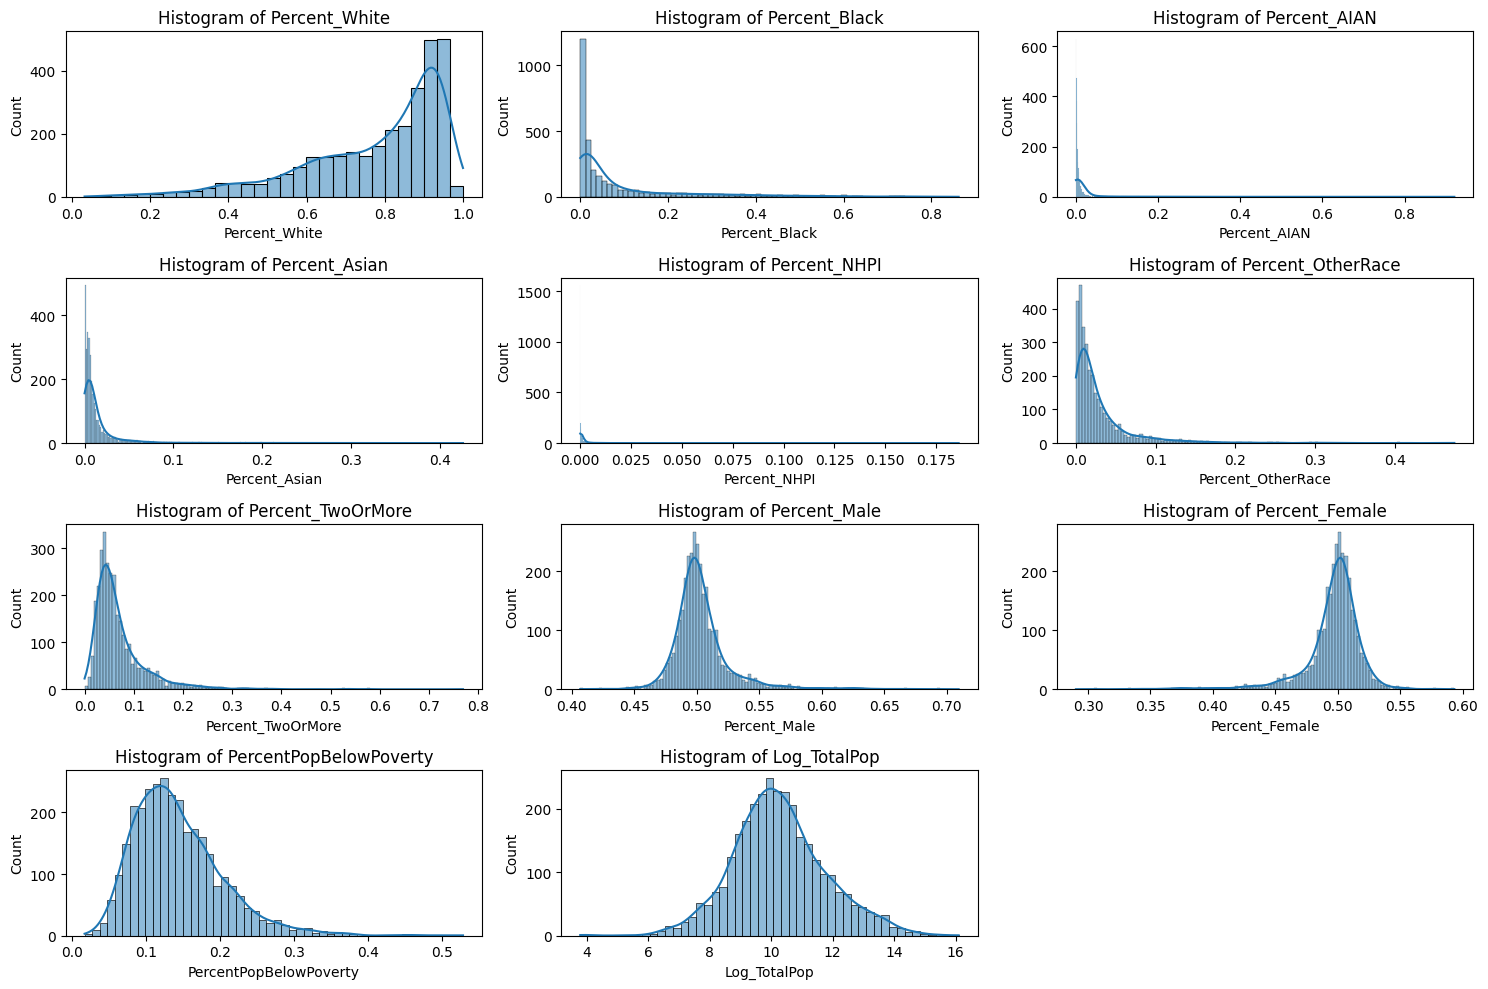

In [78]:
# Step 6: Visualize distributions of key variables

plt.figure(figsize=(15, 10))
for i, col in enumerate(df_clean.columns[:-1]):  # Exclude DHPSA
    plt.subplot(4, 3, i + 1)
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

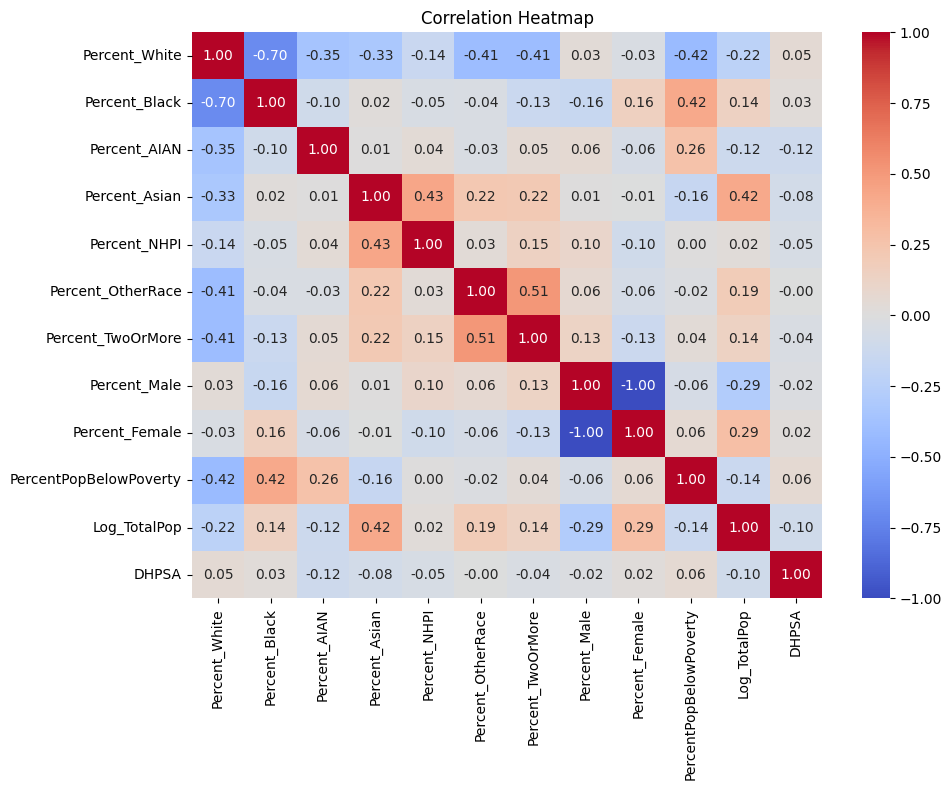

In [79]:
# Step 7: Show correlation between variables

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

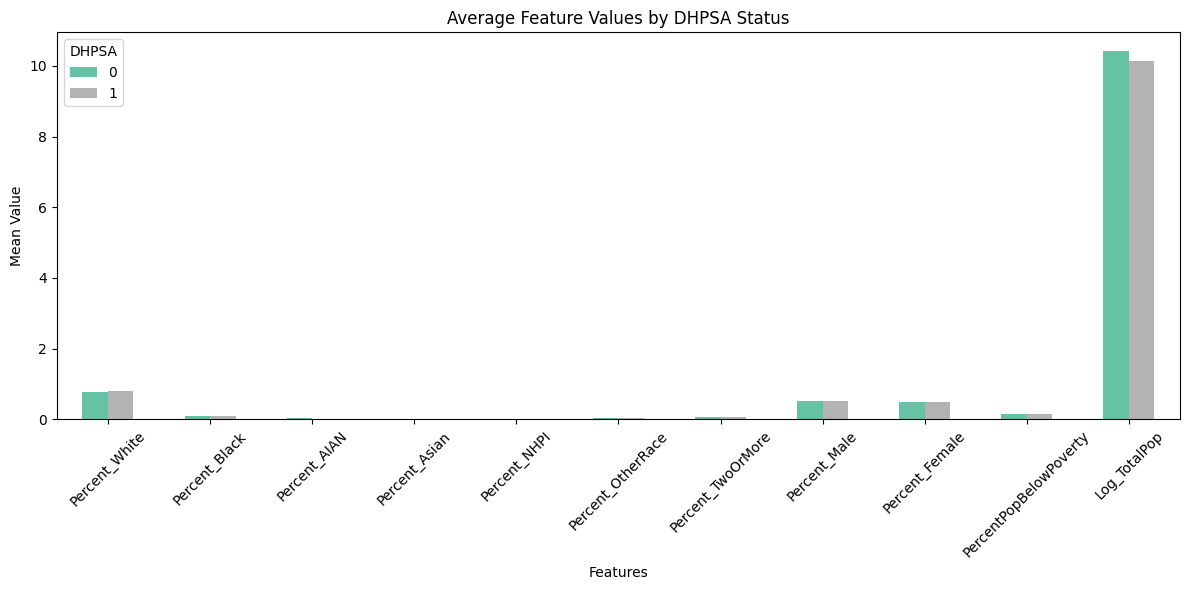

In [80]:
# Step 8: Compare mean values by DHPSA classification

avg_by_dhpsa = df_clean.groupby('DHPSA').mean().T

avg_by_dhpsa.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("Average Feature Values by DHPSA Status")
plt.ylabel("Mean Value")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

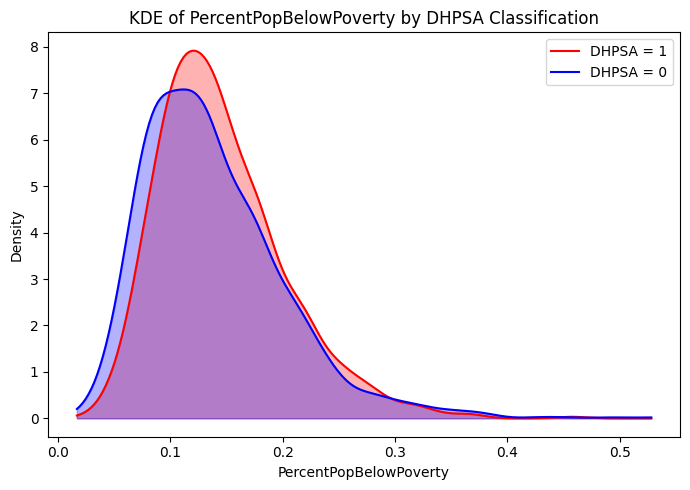

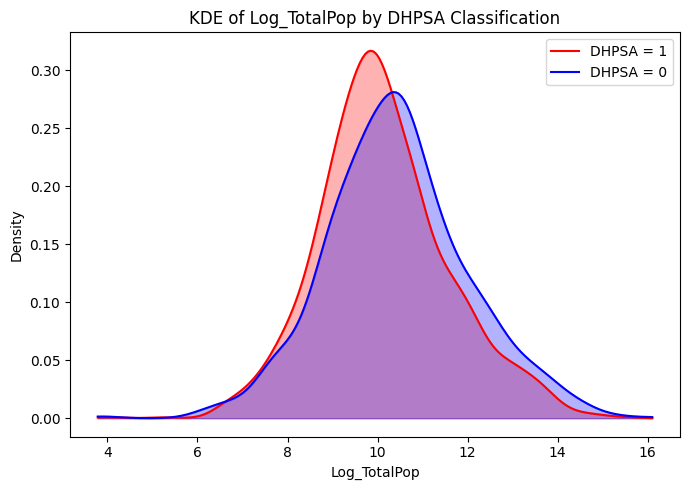

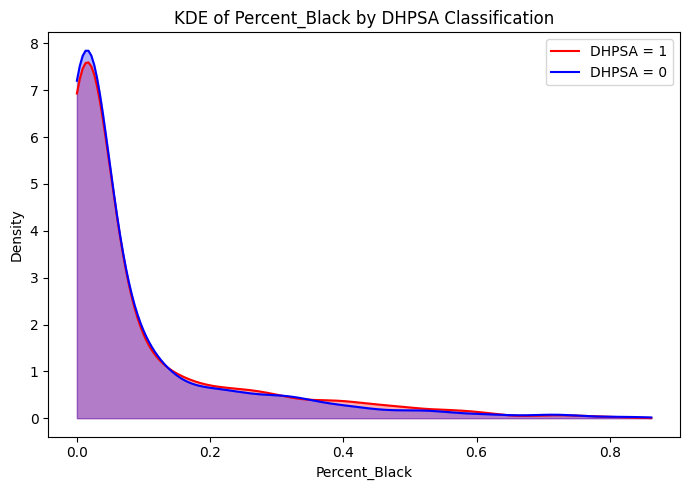

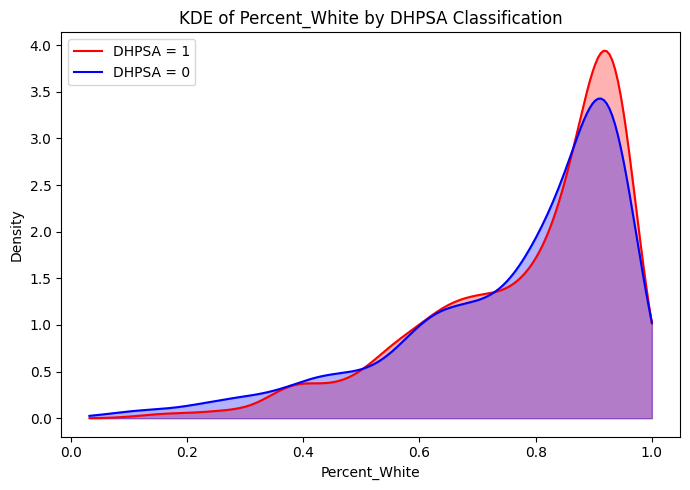

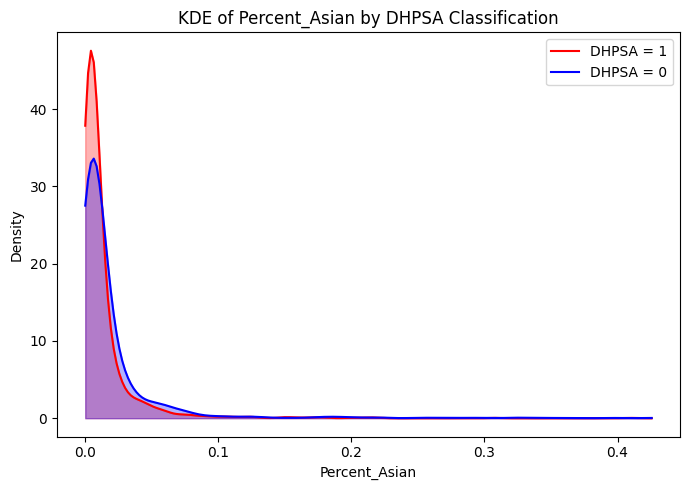

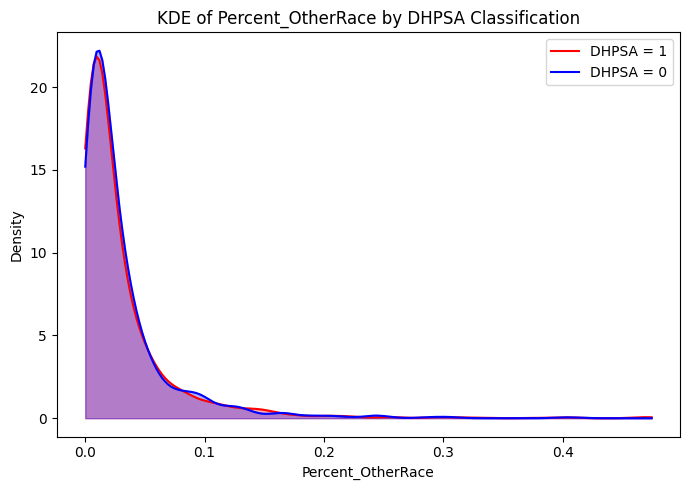

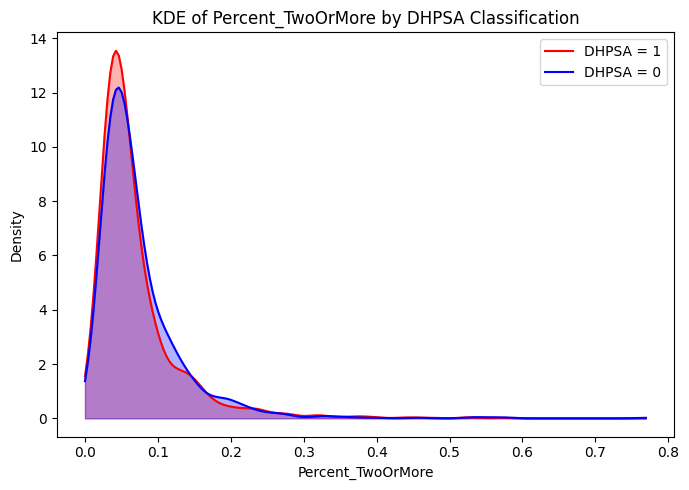

In [81]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

# List of key variables to compare
kde_columns = [
    'PercentPopBelowPoverty', 'Log_TotalPop', 'Percent_Black', 'Percent_White',
    'Percent_Asian', 'Percent_OtherRace', 'Percent_TwoOrMore'
]

# Loop through each and generate KDE plots
for col in kde_columns:
    # Split data by DHPSA class
    dhpsa_1 = df_clean[df_clean['DHPSA'] == 1][col].dropna()
    dhpsa_0 = df_clean[df_clean['DHPSA'] == 0][col].dropna()

    # Create KDE curves
    kde_1 = gaussian_kde(dhpsa_1)
    kde_0 = gaussian_kde(dhpsa_0)
    x_vals = np.linspace(df_clean[col].min(), df_clean[col].max(), 200)

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(x_vals, kde_1(x_vals), label='DHPSA = 1', color='red')
    plt.plot(x_vals, kde_0(x_vals), label='DHPSA = 0', color='blue')
    plt.fill_between(x_vals, kde_1(x_vals), alpha=0.3, color='red')
    plt.fill_between(x_vals, kde_0(x_vals), alpha=0.3, color='blue')
    plt.title(f"KDE of {col} by DHPSA Classification")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

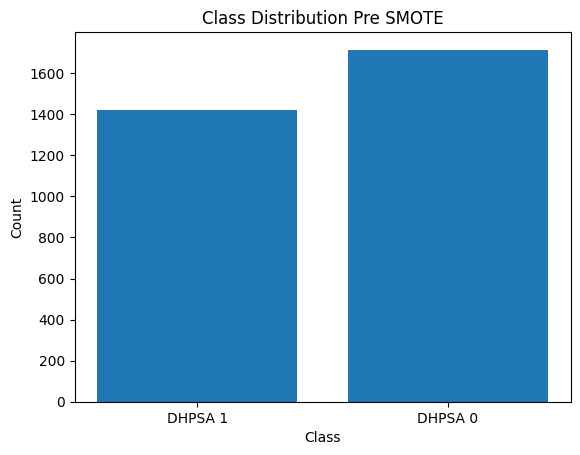

In [82]:
X = df_clean.drop(["DHPSA"],axis=1)
y = df_clean['DHPSA']
count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Pre SMOTE')
plt.xticks(count_class.index, ['DHPSA 0', 'DHPSA 1'])
plt.show()

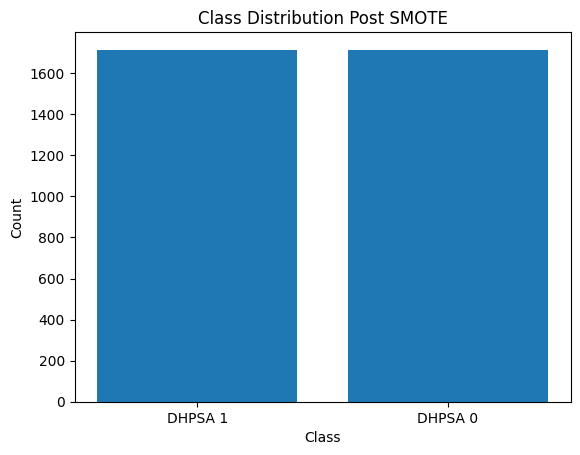

In [83]:
# Step 10A: SMOTE

X = df_clean.drop(["DHPSA"],axis=1)
y = df_clean['DHPSA']


smote=SMOTE(sampling_strategy='minority') 
x,y=smote.fit_resample(X,y)
y.value_counts()


count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Post SMOTE')
plt.xticks(count_class.index, ['DHPSA 0', 'DHPSA 1'])
plt.show()


In [84]:
# Step 10B: Train-test split and feature scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)



Feature: Percent_White, Score: 0.7191319572460827f
Feature: Percent_Black, Score: 0.915078210512017f
Feature: Percent_AIAN, Score: -2.442686154742267f
Feature: Percent_Asian, Score: -0.33724793819223914f
Feature: Percent_NHPI, Score: -0.1366190554184821f
Feature: Percent_OtherRace, Score: 1.1478645627515454f
Feature: Percent_TwoOrMore, Score: 0.28148371125411814f
Feature: Percent_Male, Score: -0.7730652564978747f
Feature: Percent_Female, Score: 0.9200705499085667f
Feature: PercentPopBelowPoverty, Score: 2.020081613885109f
Feature: Log_TotalPop, Score: -0.14905091173504223f


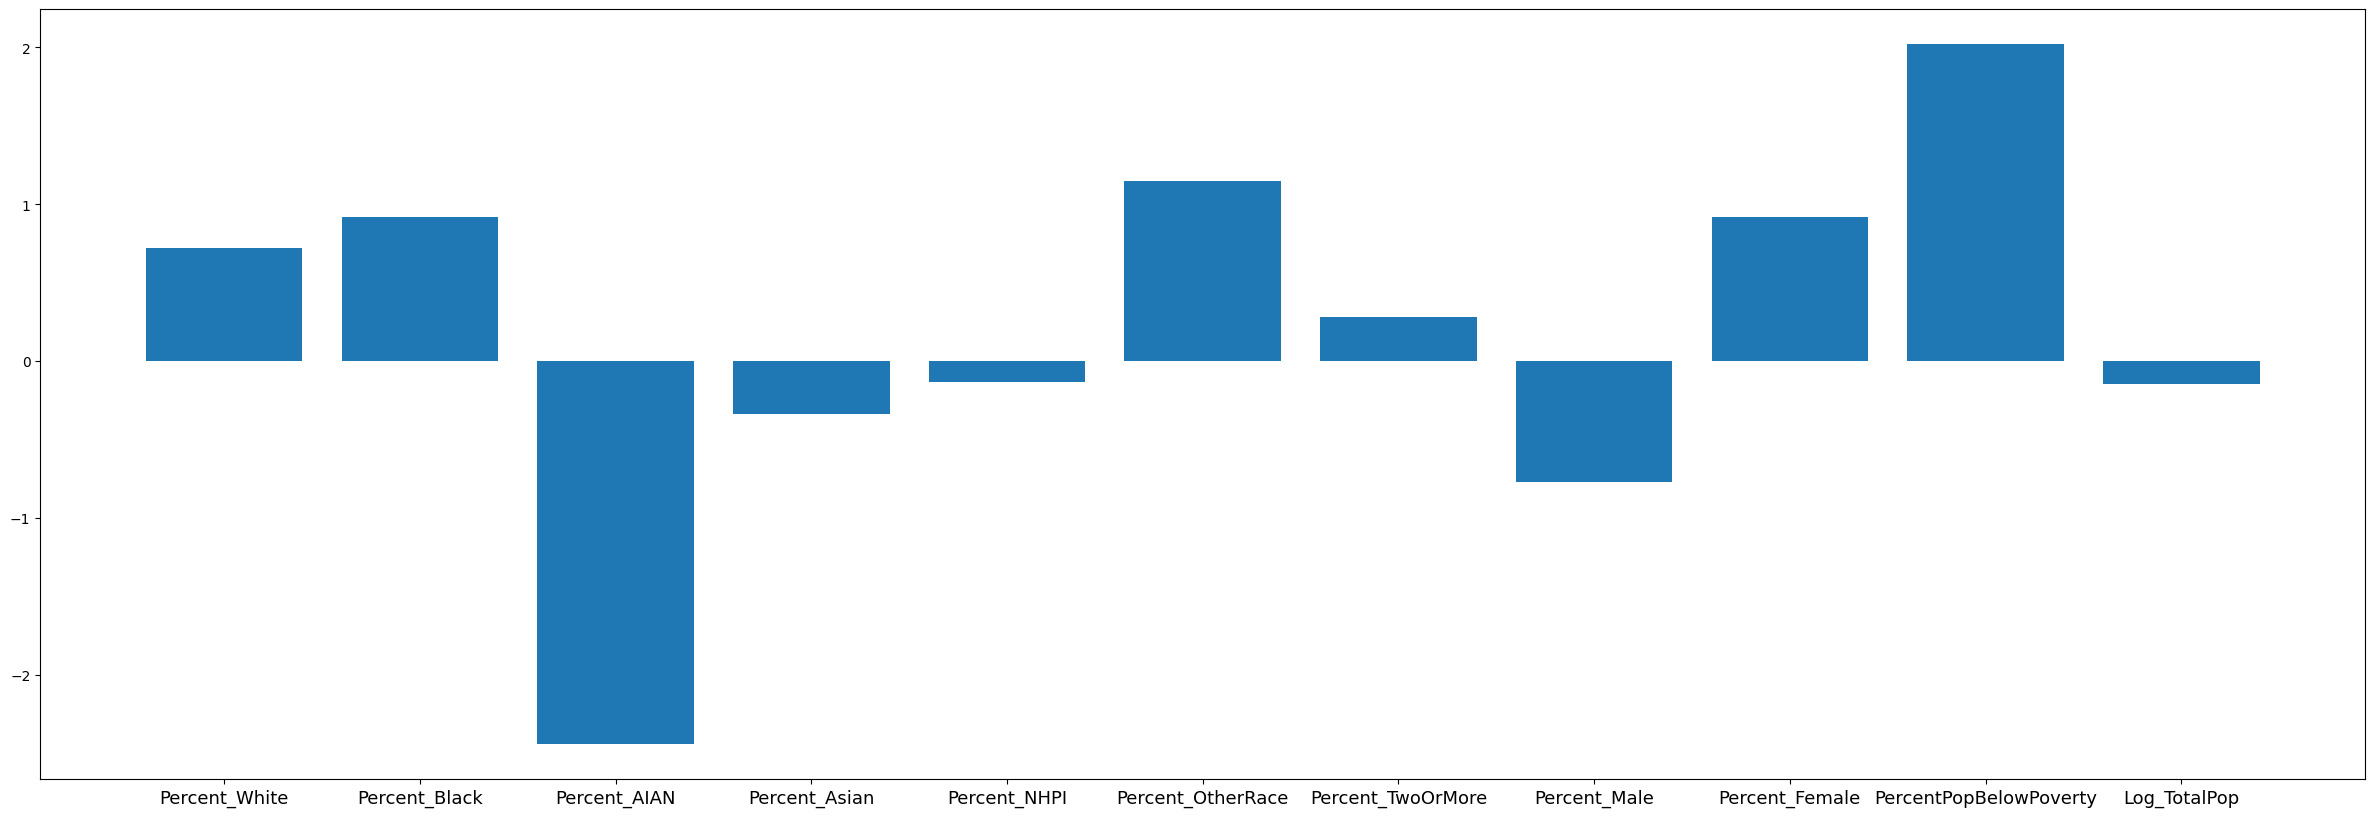

In [85]:
#Feature importance
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
columns = df_clean.columns.values.tolist()
columns.pop(-1)
importance = logreg.coef_[0]
#print feature importance
for i,v in enumerate(importance):
	print(f'Feature: {columns[i]}, Score: {v}f')
    
# plot feature importance
plt.figure(figsize=(30, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(11), columns, fontsize=13)
plt.show()

Logistic Regression Accuracy: 0.5704567541302236
[[263 250]
 [192 324]]
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       513
           1       0.56      0.63      0.59       516

    accuracy                           0.57      1029
   macro avg       0.57      0.57      0.57      1029
weighted avg       0.57      0.57      0.57      1029



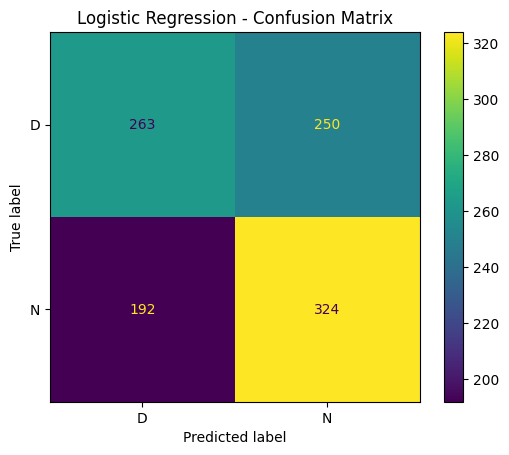

In [86]:
# Step 11: Train and evaluate logistic regression model

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logreg), display_labels=["D", "N"])
disp.plot(cmap='viridis', values_format='d')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

KNN Accuracy: 0.5665694849368319
[[412 101]
 [345 171]]
              precision    recall  f1-score   support

           0       0.54      0.80      0.65       513
           1       0.63      0.33      0.43       516

    accuracy                           0.57      1029
   macro avg       0.59      0.57      0.54      1029
weighted avg       0.59      0.57      0.54      1029



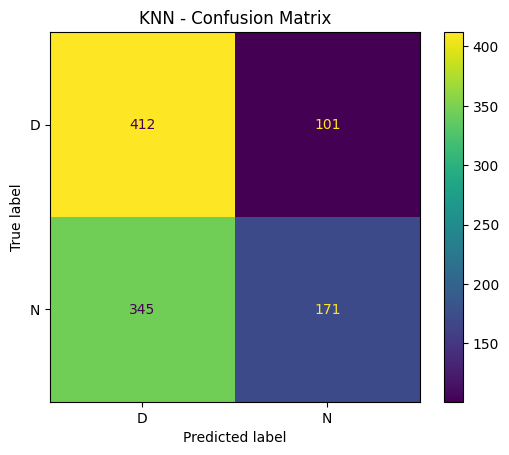

In [97]:
# Step 12: Train and evaluate KNN model

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=["D", "N"])
disp.plot(cmap='viridis', values_format='d')
plt.title("KNN - Confusion Matrix")
plt.show()

SVM Accuracy: 0.5685131195335277
[[247 266]
 [178 338]]
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       513
           1       0.56      0.66      0.60       516

    accuracy                           0.57      1029
   macro avg       0.57      0.57      0.57      1029
weighted avg       0.57      0.57      0.57      1029



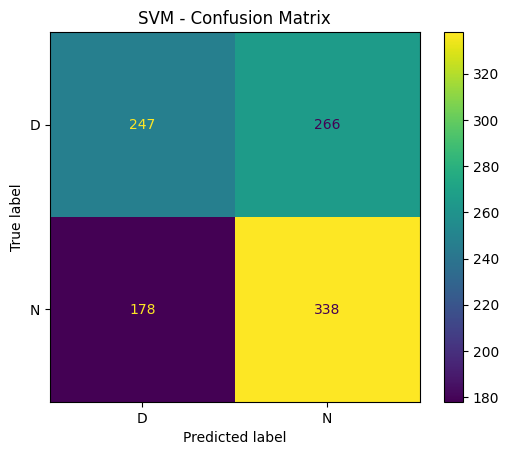

In [88]:
# Step 13: Train and evaluate SVM model

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=["D", "N"])
disp.plot(cmap='viridis', values_format='d')
plt.title("SVM - Confusion Matrix")
plt.show()

Random Forest Accuracy: 0.5821185617103984
Confusion Matrix:
 [[294 219]
 [211 305]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.57      0.58       513
           1       0.58      0.59      0.59       516

    accuracy                           0.58      1029
   macro avg       0.58      0.58      0.58      1029
weighted avg       0.58      0.58      0.58      1029



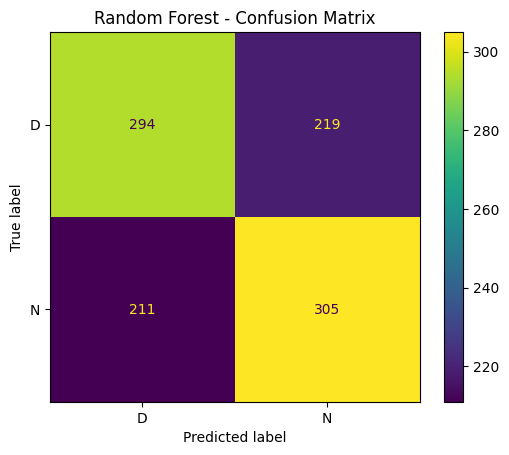

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=["D", "N"])
disp.plot(cmap='viridis', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

Classification Report:

              precision    recall  f1-score   support

           N       0.59      0.57      0.58       513
           D       0.59      0.61      0.60       516

    accuracy                           0.59      1029
   macro avg       0.59      0.59      0.59      1029
weighted avg       0.59      0.59      0.59      1029



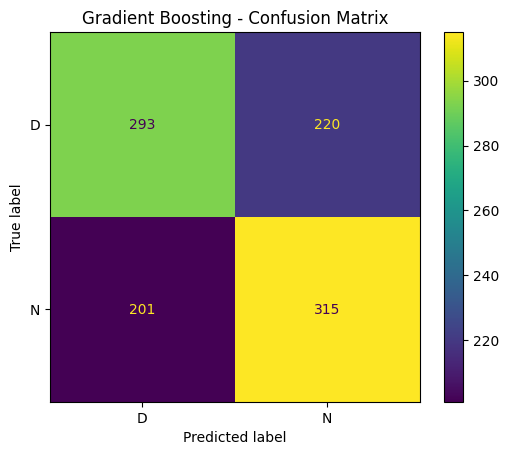

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# Train Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=2, max_depth=4, random_state=42)
gb.fit(X_train, y_train)

# Predict
y_pred_gb = gb.predict(X_test)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_gb, target_names=["N", "D"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["D", "N"])
disp.plot(cmap='viridis', values_format='d')
plt.title("Gradient Boosting - Confusion Matrix")
plt.show()

In [91]:
# Compare model performance
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "KNN", "SVM", "Random Forest", "Gradient Boosting"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ]
})

results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

,Model,Accuracy
0,Gradient Boosting,0.590865
1,Random Forest,0.582119
2,Logistic Regression,0.570457
3,SVM,0.568513
4,KNN,0.566569


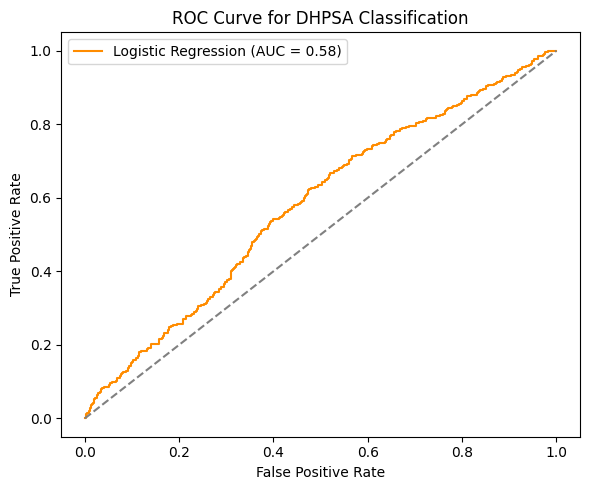

In [92]:
# Step 14: Plot ROC curve for logistic regression

y_probs = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for DHPSA Classification")
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Create dictionary for each model and predictions
models_info = {
    "Logistic Regression": (y_pred_logreg, logreg.predict_proba(X_test)[:, 1]),
    "KNN": (y_pred_knn, knn.predict_proba(X_test)[:, 1]),
    "SVM": (y_pred_svm, svm.predict_proba(X_test)[:, 1]),
    "Random Forest": (y_pred_rf, rf.predict_proba(X_test)[:, 1]),
    "Gradient Boosting": (y_pred_gb, gb.predict_proba(X_test)[:, 1])
}

# Compile metrics
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC": []
}

for name, (y_pred, y_probs) in models_info.items():
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-Score"].append(f1_score(y_test, y_pred))
    metrics["AUC"].append(roc_auc_score(y_test, y_probs))

# Create and display DataFrame
full_results_df = pd.DataFrame(metrics)
full_results_df = full_results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
full_results_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Gradient Boosting,0.590865,0.588785,0.610465,0.599429,0.603558
1,Random Forest,0.582119,0.582061,0.591085,0.586538,0.629229
2,Logistic Regression,0.570457,0.564460,0.627907,0.594495,0.579729
3,SVM,0.568513,0.559603,0.655039,0.603571,0.578585
4,KNN,0.566569,0.628676,0.331395,0.434010,0.598592


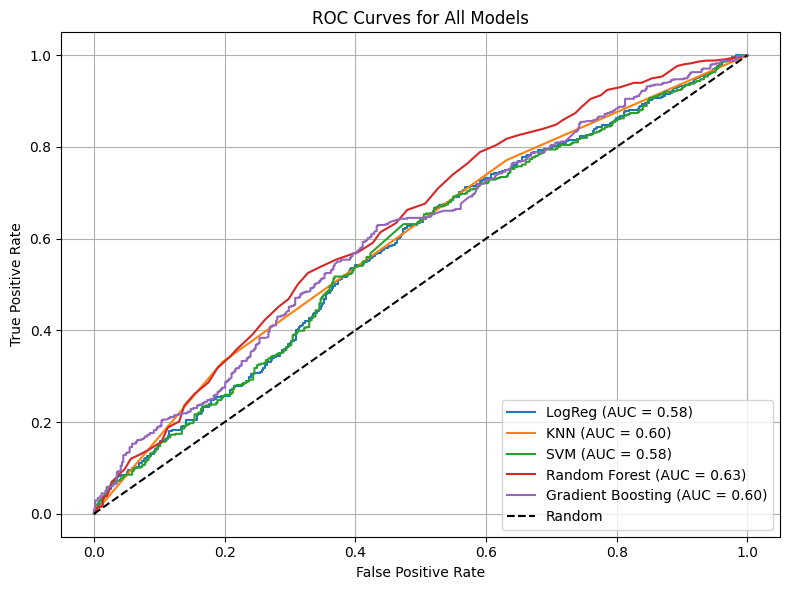

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_probs_logreg = logreg.predict_proba(X_test)[:, 1]
y_probs_knn = knn.predict_proba(X_test)[:, 1]
y_probs_svm = svm.predict_proba(X_test)[:, 1]
y_probs_rf = rf.predict_proba(X_test)[:, 1]
y_probs_gb = gb.predict_proba(X_test)[:, 1]

# Compute FPR, TPR for each model
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_probs_logreg)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_probs_knn)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_probs_gb)

# Compute AUCs
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_knn = auc(fpr_knn, tpr_knn)
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)
auc_gb = auc(fpr_gb, tpr_gb)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUC = {auc_logreg:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

/home/students/mgw11/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 1019/1029 [00:20<00:00]       

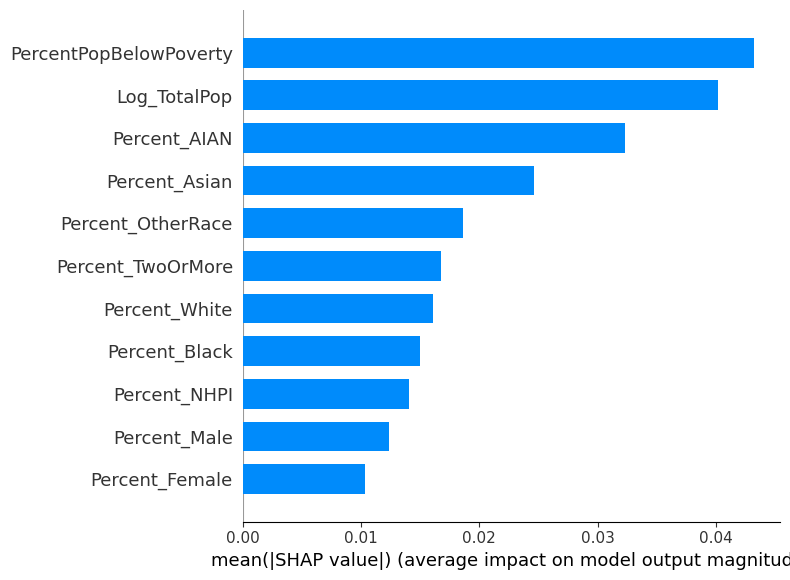

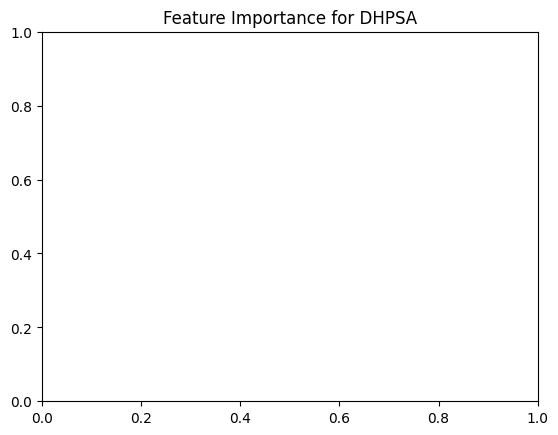

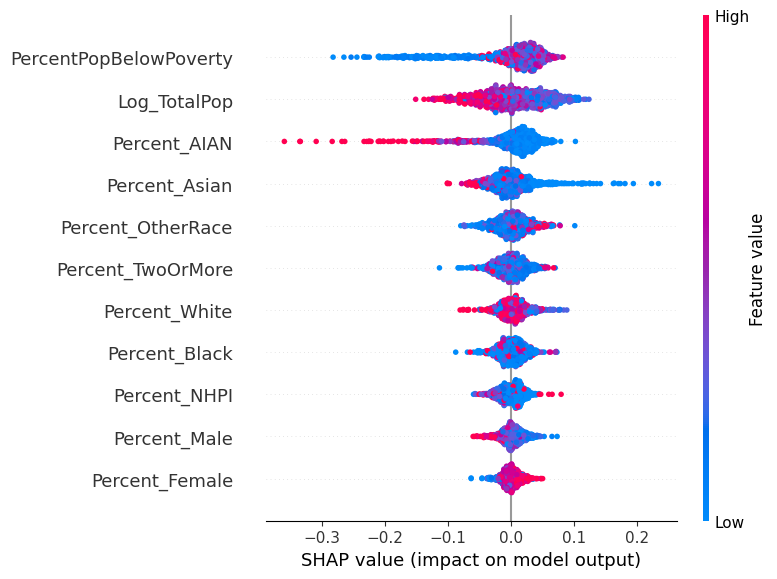

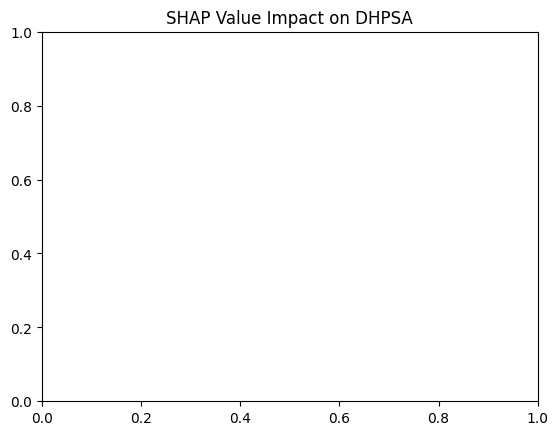

In [23]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor  # or Classifier if DHPSA is categorical

# 1. First train an actual model (example with RandomForest)
# Assuming:
# X_train_scaled, X_test_scaled are your scaled features
# y_train, y_test are your target (DHPSA)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 3. Summary plot (feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")
plt.title("Feature Importance for DHPSA")
plt.show()

# 4. Beeswarm plot (shows impact direction)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.title("SHAP Value Impact on DHPSA")
plt.show()

In [24]:
# Step 16: Chi-Square tests for binned variables vs DHPSA

# Define which continuous columns to bin
columns_to_test = [
    'PercentPopBelowPoverty', 'Percent_White', 'Percent_Black', 'Percent_Asian',
    'Percent_OtherRace', 'Percent_TwoOrMore', 'Percent_Male', 'Log_TotalPop'
]

# Create and test each
for col in columns_to_test:
    df_clean[f"{col}_bin"] = pd.qcut(df_clean[col], q=2, labels=["Low", "High"])
    table = pd.crosstab(df_clean[f"{col}_bin"], df_clean['DHPSA'])
    chi2, p, _, _ = chi2_contingency(table)
    print(f"Chi-Square for {col}: p-value = {p:.9f}")

Chi-Square for PercentPopBelowPoverty: p-value = 0.000465807
Chi-Square for Percent_White: p-value = 0.027236383
Chi-Square for Percent_Black: p-value = 0.257717418
Chi-Square for Percent_Asian: p-value = 0.000021401
Chi-Square for Percent_OtherRace: p-value = 0.030091562
Chi-Square for Percent_TwoOrMore: p-value = 0.000313401
Chi-Square for Percent_Male: p-value = 0.274581533
Chi-Square for Log_TotalPop: p-value = 0.000000001


/tmp/ipykernel_2638211/318611485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"{col}_bin"] = pd.qcut(df_clean[col], q=2, labels=["Low", "High"])
/tmp/ipykernel_2638211/318611485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f"{col}_bin"] = pd.qcut(df_clean[col], q=2, labels=["Low", "High"])
/tmp/ipykernel_2638211/318611485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [25]:
# Step 17: Mann-Whitney U tests between DHPSA groups for continuous variables

for col in columns_to_test:
    group1 = df_clean[df_clean['DHPSA'] == 1][col]
    group0 = df_clean[df_clean['DHPSA'] == 0][col]
    u_stat, p_val = mannwhitneyu(group1, group0)
    print(f"Mann-Whitney U Test for {col}: p-value = {p_val:.9f}")


Mann-Whitney U Test for PercentPopBelowPoverty: p-value = 0.000002030
Mann-Whitney U Test for Percent_White: p-value = 0.009646973
Mann-Whitney U Test for Percent_Black: p-value = 0.136263619
Mann-Whitney U Test for Percent_Asian: p-value = 0.000000005
Mann-Whitney U Test for Percent_OtherRace: p-value = 0.037196040
Mann-Whitney U Test for Percent_TwoOrMore: p-value = 0.000373957
Mann-Whitney U Test for Percent_Male: p-value = 0.042261336
Mann-Whitney U Test for Log_TotalPop: p-value = 0.000000003


In [26]:
# Step 19: Wilcoxon test — artificial matched sampling

from scipy.stats import wilcoxon

print("\nWilcoxon Test (on 1000-sample matched subset):\n")
for col in columns_to_test:
    try:
        dhpsa_1 = df_clean[df_clean['DHPSA'] == 1][col].sample(1000, random_state=42).reset_index(drop=True)
        dhpsa_0 = df_clean[df_clean['DHPSA'] == 0][col].sample(1000, random_state=42).reset_index(drop=True)
        stat, p_w = wilcoxon(dhpsa_1, dhpsa_0)
        print(f"{col}: p-value = {p_w:.4f}")
    except Exception as e:
        print(f"{col}: Wilcoxon error - {e}")



Wilcoxon Test (on 1000-sample matched subset):

PercentPopBelowPoverty: p-value = 0.0652
Percent_White: p-value = 0.0071
Percent_Black: p-value = 0.5841
Percent_Asian: p-value = 0.0000
Percent_OtherRace: p-value = 0.8105
Percent_TwoOrMore: p-value = 0.0238
Percent_Male: p-value = 0.6511
Log_TotalPop: p-value = 0.0000


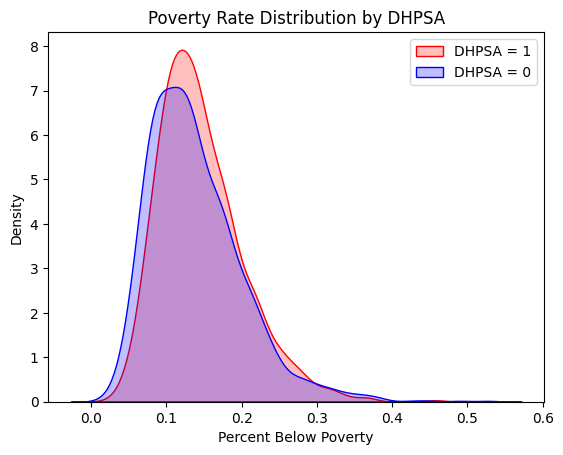

/tmp/ipykernel_2638211/3973931630.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DHPSA', y='PercentPopBelowPoverty', data=df_clean, palette='Set2')


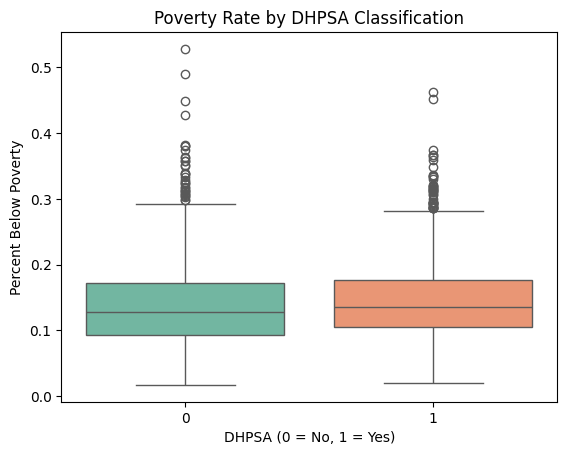

In [27]:
# KDE Plot: Poverty
sns.kdeplot(df_clean[df_clean['DHPSA'] == 1]['PercentPopBelowPoverty'], label='DHPSA = 1', fill=True, color='red')
sns.kdeplot(df_clean[df_clean['DHPSA'] == 0]['PercentPopBelowPoverty'], label='DHPSA = 0', fill=True, color='blue')
plt.title("Poverty Rate Distribution by DHPSA")
plt.xlabel("Percent Below Poverty")
plt.legend()
plt.show()

# Boxplot
sns.boxplot(x='DHPSA', y='PercentPopBelowPoverty', data=df_clean, palette='Set2')
plt.title("Poverty Rate by DHPSA Classification")
plt.xlabel("DHPSA (0 = No, 1 = Yes)")
plt.ylabel("Percent Below Poverty")
plt.show()

/tmp/ipykernel_2638211/50907965.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DHPSA', y='Log_TotalPop', data=df_clean, palette='Set3')


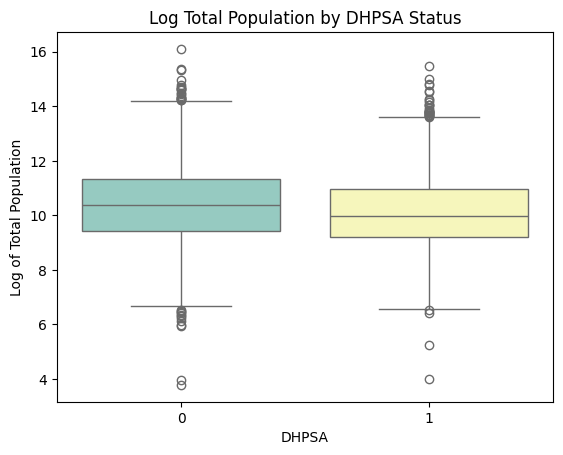

In [28]:
sns.boxplot(x='DHPSA', y='Log_TotalPop', data=df_clean, palette='Set3')
plt.title("Log Total Population by DHPSA Status")
plt.xlabel("DHPSA")
plt.ylabel("Log of Total Population")
plt.show()


/tmp/ipykernel_2638211/1428585140.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DHPSA', y='Percent_Black', data=df_clean, palette='coolwarm')


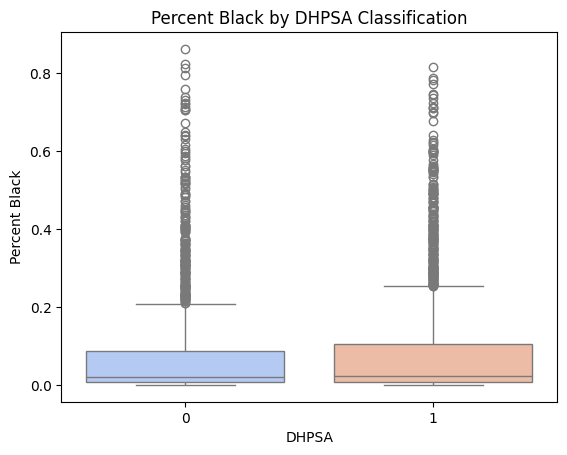

/tmp/ipykernel_2638211/1428585140.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DHPSA', y='Percent_White', data=df_clean, palette='coolwarm')


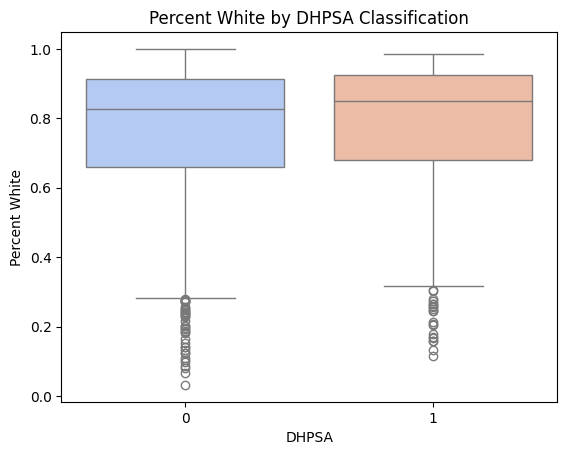

In [29]:
# Percent Black
sns.boxplot(x='DHPSA', y='Percent_Black', data=df_clean, palette='coolwarm')
plt.title("Percent Black by DHPSA Classification")
plt.xlabel("DHPSA")
plt.ylabel("Percent Black")
plt.show()

# Percent White
sns.boxplot(x='DHPSA', y='Percent_White', data=df_clean, palette='coolwarm')
plt.title("Percent White by DHPSA Classification")
plt.xlabel("DHPSA")
plt.ylabel("Percent White")
plt.show()

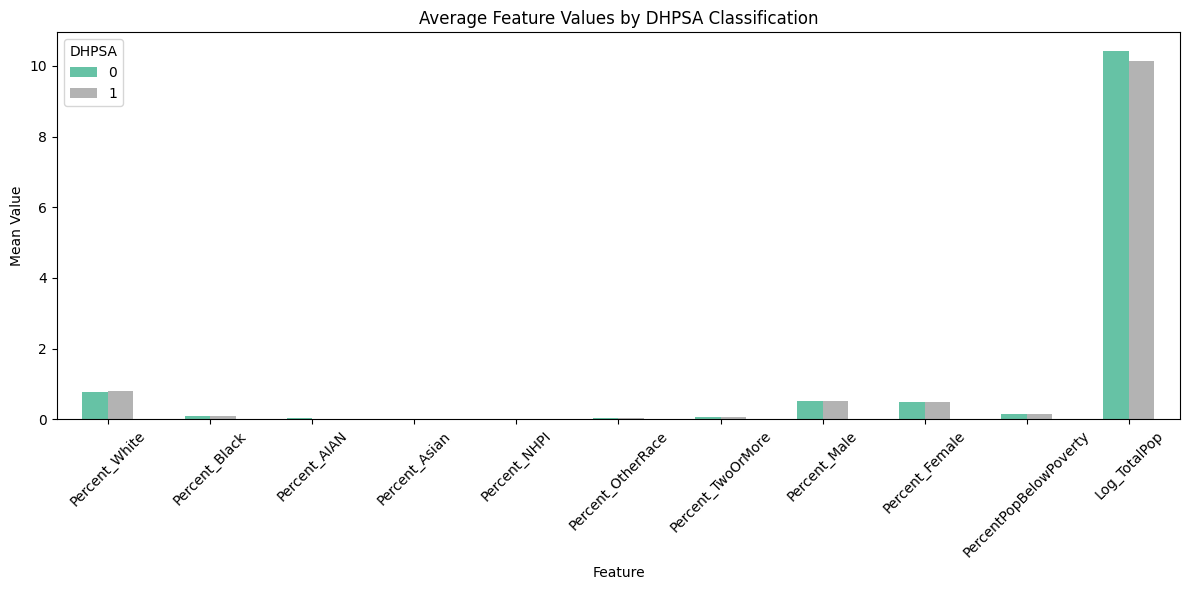

In [30]:
# Fix: Select only numeric columns
numeric_cols = df_clean.select_dtypes(include=['number']).columns.drop('DHPSA')

# Compute means
avg_by_dhpsa = df_clean.groupby('DHPSA')[numeric_cols].mean().T

# Plot
avg_by_dhpsa.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("Average Feature Values by DHPSA Classification")
plt.ylabel("Mean Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()